In [49]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
def f(x):
    return 3*x**2 - 4*x +5

In [51]:
f(3.0)

20.0

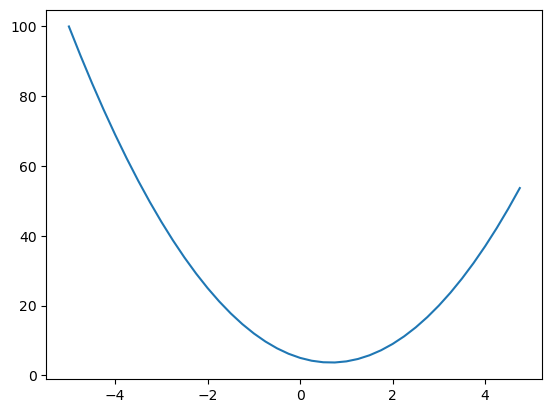

In [52]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [53]:
h = 0.000000000001
x = 0.66666
d = (f(x+h)-f(x))/h
d

0.0004440892098500626

In [54]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
d

4.0

In [55]:
h=0.0001

a=2.0
b=-3.0
c=10.0
d1=a*b+c

b+=h
d2= a*b+c
print("d1", d1)
print("d2",d2)
print("slope",(d2-d1)/h)


d1 4.0
d2 4.0002
slope 2.0000000000042206


## Lets start building up a backpropagation network

In [124]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other,(self,),f'**{other}')
    def _backward():
      self.grad += other * self.data ** (other - 1) * out.grad
    out._backward = _backward
    return out


  def __rmul__(self, other):
    return self * other
  def __radd__(self, other):
    return self + other
  
  def __truediv__(self, other):
    return self * other**-1
  
  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
      
a=Value(2.0,label="a")
b= Value(-3.0,label="b")
c = Value(10.0, label="c")
e=a*b; e.label="e"
d=e+c; d.label="d"
f=Value(-2.0,label="f")
L = d*f; L.label="L"
L


Value(data=-8.0)

In [57]:
a = Value(2)
b = Value(4)
a - b

Value(data=-2)

In [58]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [59]:
d._op

'+'

In [60]:
from graphviz import Digraph
def trace(root):
    nodes,edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir":"LR"})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label= "{%s | data %.4f | grad %.4f}" % (n.label ,n.data, n.grad ), shape= "record")
        if n._op:
            dot.node(name=uid + n._op, label= n._op)
            dot.edge(uid + n._op, uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [61]:
#Gradient of dL
d.grad=-2
#Gradient of fL
f.grad=4
#Gradient of dL/dL
L.grad=1


#Derivative of L in respect to e
# Chain rule 
# dL/dc = (dL/dd) * (dd/dc)

# Because dd/dc = 1 
# Gradient of dL/dc will be the same as grad of dL/dd 

c.grad=-2
e.grad=-2

# Chain rule again

# dL / da = (dL /de) * (de/da)
# de / da = b 

a.grad = (-2 * -3)
b.grad = (-2 * 2)

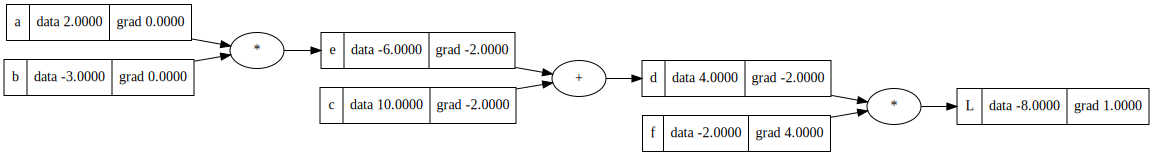

In [62]:
draw_dot(L)

## Lets backpropagate through a neuron ! 

In [63]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


In [64]:
"""
o.grad=1.0

# Local derivitave of tanh 
# o = tanh(n)
# do/dn = 1 - tanh(n)**2
# do/dn = 1 - o**2
n.grad = 0.5

x1w1x2w2.grad=0.5
b.grad=0.5


x1w1.grad=0.5
x2w2.grad=0.5

x2.grad = 0.5
w2.grad = 0.0

x1.grad = -1.5
w1.grad = 1
"""

'\no.grad=1.0\n\n# Local derivitave of tanh \n# o = tanh(n)\n# do/dn = 1 - tanh(n)**2\n# do/dn = 1 - o**2\nn.grad = 0.5\n\nx1w1x2w2.grad=0.5\nb.grad=0.5\n\n\nx1w1.grad=0.5\nx2w2.grad=0.5\n\nx2.grad = 0.5\nw2.grad = 0.0\n\nx1.grad = -1.5\nw1.grad = 1\n'

In [65]:
o.grad = 1.0



topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

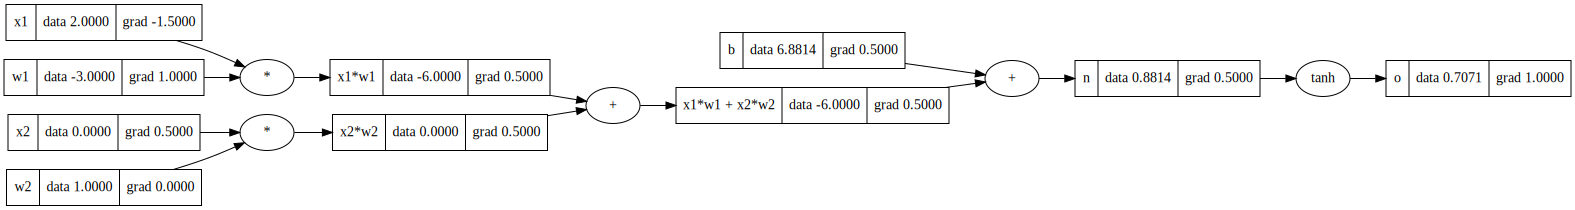

In [66]:
draw_dot(o)

*Lets start automating this*

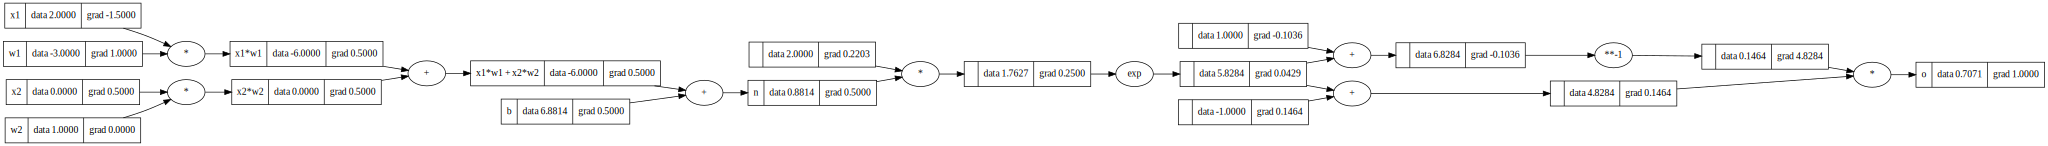

In [67]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label= 'o'
o.backward()
draw_dot(o)


In [83]:
import random

In [130]:
class Neuron: 

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x= layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [143]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.7813909326874463)

In [144]:
len(n.parameters())

41

In [145]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [146]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.7813909326874463),
 Value(data=-0.21081859781153947),
 Value(data=-0.5299531262796229),
 Value(data=0.8292342766716083)]

In [147]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss
loss.backward()


In [148]:
n.layers[0].neurons[0].w[0].grad

-4.161044877295961

In [159]:
for k in range(100):
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0.0

    loss.backward()

    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)


0 0.003076990548737977
1 0.003058414445815699
2 0.0030400516370409506
3 0.003021898537581989
4 0.0030039516416477483
5 0.0029862075203363108
6 0.002968662819552999
7 0.002951314257995284
8 0.0029341586252023444
9 0.0029171927796665734
10 0.0029004136470049454
11 0.0028838182181879475
12 0.0028674035478240176
13 0.0028511667524976137
14 0.002835105009158567
15 0.0028192155535614197
16 0.002803495678752671
17 0.002787942733604036
18 0.0027725541213906276
19 0.0027573272984119206
20 0.0027422597726543658
21 0.002727349102494106
22 0.002712592895438279
23 0.0026979888069037766
24 0.002683534539032024
25 0.0026692278395386597
26 0.0026550665005967726
27 0.002641048357752786
28 0.0026271712888736552
29 0.0026134332131244505
30 0.002599832089975409
31 0.0025863659182372477
32 0.0025730327351238596
33 0.0025598306153417683
34 0.0025467576702050947
35 0.0025338120467753114
36 0.0025209919270251834
37 0.002508295527025846
38 0.002495721096156356
39 0.0024832669163351822
40 0.002470931301272579
4

In [160]:
ypred

[Value(data=0.9811390600782396),
 Value(data=-0.9846357097682787),
 Value(data=-0.9737611954009021),
 Value(data=0.9749855815792494)]

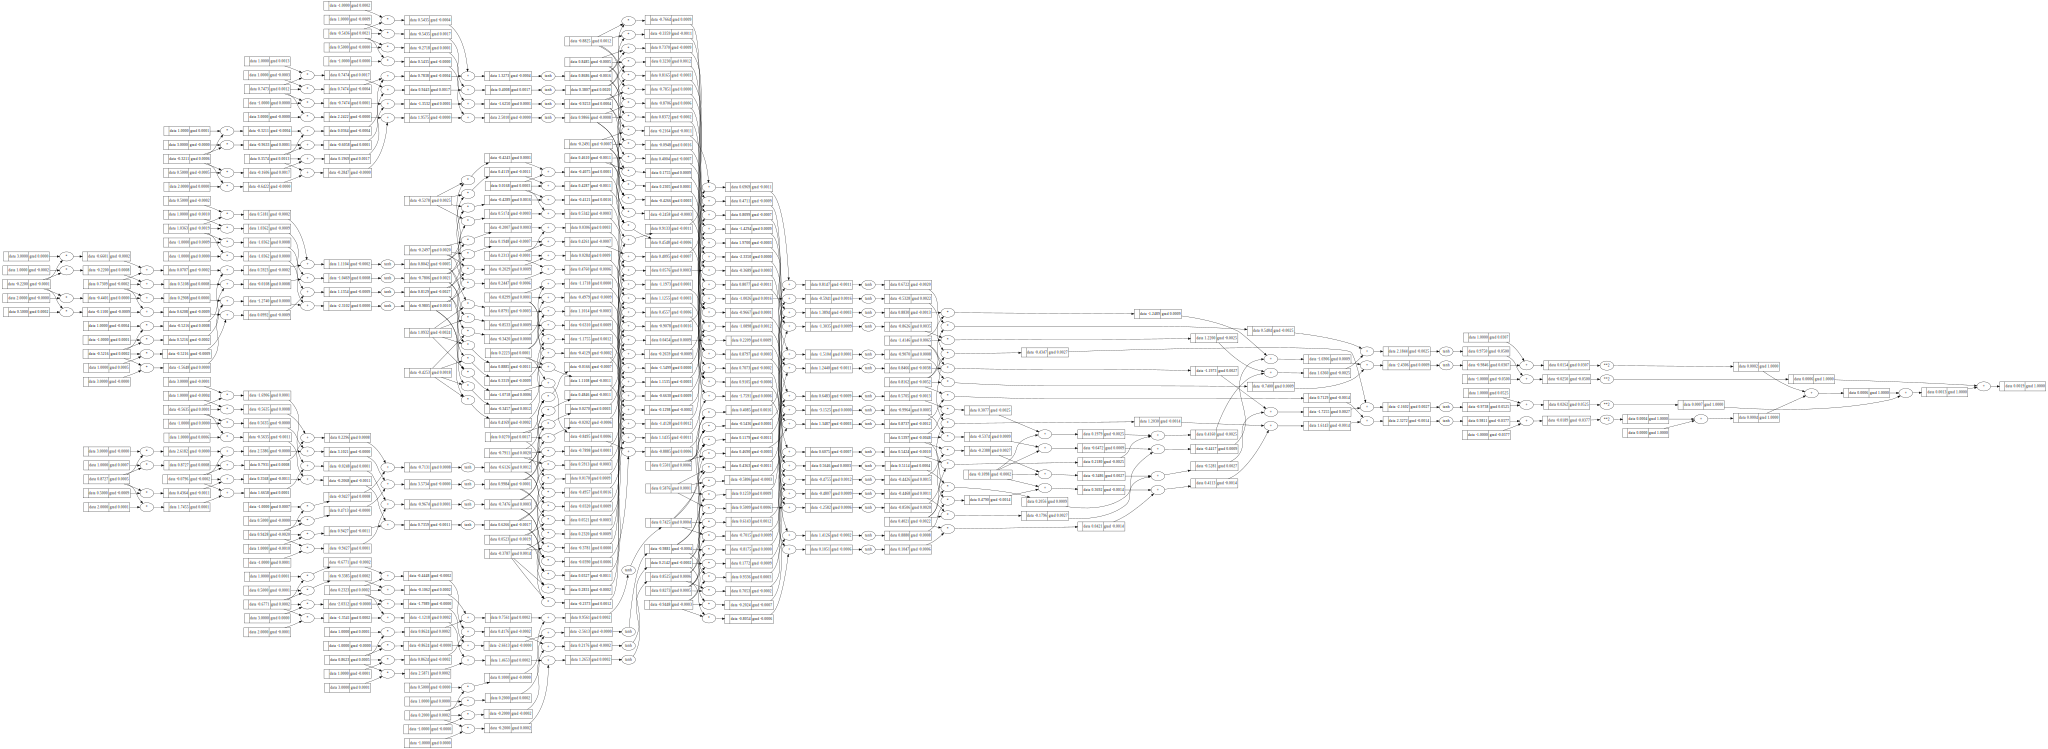

In [161]:
draw_dot(loss)